In [301]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from scipy import stats
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression

%matplotlib inline
warnings.filterwarnings('ignore')

In [302]:
train_data = pd.read_csv('train.csv')

train_data.sample(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
202,4123,106,2.0,62.688077,35.200267,10.0,8,18.0,2004,0.246032,B,A,22,3151,4,2715.0,3,3,B,260776.913797
5295,10469,11,3.0,67.657741,44.458409,7.0,7,12.0,1975,0.000170,B,B,36,5992,0,NaN,1,1,B,249618.400128
8895,1253,84,2.0,45.076504,28.258104,5.0,4,5.0,1960,0.006076,B,B,30,5285,0,645.0,6,6,B,213784.432208
3487,1057,27,2.0,54.755388,5.662233,1.0,12,17.0,2018,0.011654,B,B,4,915,0,NaN,0,0,B,150281.357110
9721,396,54,3.0,110.119100,110.333763,1.0,8,1.0,2015,0.006076,B,B,30,5285,0,645.0,6,6,B,491296.245173
6267,5633,27,3.0,87.639998,NaN,1.0,3,1.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,267402.216037
8413,8276,97,1.0,41.863856,20.805127,7.0,14,17.0,2001,0.306977,B,B,27,5148,14,1575.0,5,7,B,256075.502012
4550,16408,9,1.0,40.226907,37.849083,19.0,8,17.0,1993,0.161532,B,B,25,5648,1,30.0,2,4,B,137595.610782
4367,11808,78,1.0,40.068879,25.478884,6.0,11,9.0,1974,0.219006,B,B,28,6746,3,NaN,1,4,B,144498.687457
2605,14920,61,1.0,40.224554,22.151200,6.0,7,9.0,1976,0.300323,B,B,52,10311,6,NaN,1,9,B,189919.823101


### Описание датасета
* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

In [303]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

## Exploratory data analysis

In [304]:
train_data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [305]:
# кол-во значений в признаках
# переведем признаки с небльшим кол-во значений в категориальные
pd.DataFrame({item:len(train_data[item].unique()) for item in train_data[train_data.columns.tolist()].select_dtypes(include=['int64', 'float64']).columns.tolist()}.items(), \
columns = ['Name', 'Count']).sort_values(by='Count').head(13)

,Name,Count
14,Helthcare_2,7
2,Rooms,9
15,Shops_1,16
12,Social_3,30
6,Floor,33
7,HouseFloor,44
10,Social_1,51
5,KitchenSquare,58
13,Healthcare_1,80
8,HouseYear,97


### класс конвейера

In [306]:
class DataFrame(pd.DataFrame):
    """расширение DataFrame"""
    @property    
    def column_num(self):
        """количественные признаки"""
        return self[self.columns.tolist()].select_dtypes(include=['int64', 'float64']).columns.tolist()
        
    @property    
    def column_cat(self):
        """номинативные признаки"""
        return self[self.columns.tolist()].select_dtypes(include=['object', 'category']).columns.tolist()    
    
class DataPipeline:     
    def __init__(self, **kwargs):
        """Инициализация класса"""                 
        # уровень стат значимости
        self.alpha = 0.05
        # пороговое значение в три сигмы
        self.threashold = 3              
        # параметры класса
        for key, value in kwargs.items():
            setattr(self, key, value)    
            
        assert self.train_file is not None
        self.train_data = DataFrame(pd.read_csv(self.train_file))
        
        assert self.test_file is not None                   
        self.test_data = DataFrame(pd.read_csv(self.test_file))
    
    def sc_data(func):
        """Декоратор стандартизации"""
        def wrapper(self):         
            scaler = StandardScaler()                                    
            # стандартизация обучения                    
            self.train_data = func(self, self.train_data)
            #print(self.train_data["HouseYear"].agg({'min','max','mean'}))               
            column = [item for item in self.train_data.column_num if item != self.target]                        
            self.sc_train_data = DataFrame(scaler.fit_transform(self.train_data[column]), columns=column)
            # стандартизация теста
            self.test_data = func(self, self.test_data)            
            column = [item for item in self.test_data.column_num if item != self.target]            
            self.sc_test_data = DataFrame(scaler.transform(self.test_data[column]), columns=column)
                        
        return wrapper    
    
    @sc_data
    def transform(self, data):       
        """Трансформация данных"""  
        # удаляем id
        data.drop("Id", axis=1, inplace=True)            
        # значений не много переводим в категориальный тип
        data.DistrictId = data.DistrictId.astype("category")
        
        data.Social_1 = data.Social_1.astype("category")
        data.Social_2 = data.Social_2.astype("category")
        data.Social_3 = data.Social_3.astype("category")

        data.Shops_1 = data.Shops_1.astype("category")
        data.Shops_2 = data.Shops_2.astype("category")
        
        data.Healthcare_1 = data.Healthcare_1.astype("category")
        data.Helthcare_2  = data.Helthcare_2.astype("category")

        # обработка категориальных признаков
        for item in data.column_cat:        
            data = self._transform_cat_(data, item)            
        # обработка количественных признаков
        for item in data.column_num:
            data = self._transform_num_(data, item)
        
        return data
            
    def _transform_cat_(self, data, column):
        """Трансформация категориальных признаков"""                
        # заменяем пропуски модой                                   
        data[column] = data[column].fillna(data[column].mode()[0])                    
        # кодируем признак
        data[column] = LabelEncoder().fit_transform(data[column])
        
        return data
        
    def _transform_num_(self, data, column):
        """Трансформация количественных признаков"""                      
        # запомнинание пропусков
        data['isna'] = np.where(data[column].isna(), True, False)                        
        # заполнение пропусков
        data[column] = data[column].fillna(data[column].mean())
        # обработка выбрасов, вычисляем z-Score        
        while True:
            z = np.abs(stats.zscore(data[column]))                                                     
            if not z[z > self.threashold].any():
                break            
            # среднее если данные имеют нормальное распределение, иначе медиана                                    
            if stats.shapiro(data[column].values.reshape(-1))[1] < self.alpha:                        
                data.loc[z > self.threashold, column] = data[column].median()            
            else:            
                data.loc[z > self.threashold, column] = data[column].mean()                                                
        # винсоризация, zscore почему-то не убирает некоторые значительные выбросы
        #data[column] = winsorize(data[column], limits=[0.1, 0.1])                                      
        # обработка пропусков             
        if True in data['isna'].values:
            # используем простую модель
            model = LinearRegression()
            # формируем обучающие и тестовые наборы
            X_test = data[data['isna']==True][[item for item in data.columns if item != column]]
            X_train = data[data['isna']==False][[item for item in data.columns if item != column]]        
            y_train = data[data['isna']==False][[column]]        
            # обучение модели
            model.fit(X_train, y_train)
            # выполняем предсказание прзнака
            data[data['isna']][column] = model.predict(X_test)            
        data.drop('isna', axis=1, inplace=True)            
        
        return data
        
    def fit(self):
        """Обучение модели"""    
        display(self.sc_train_data.sample(10))
        display(self.sc_train_data.describe())            
        
    def plot(self, data):      
        """график plot"""           
        for column in data.column_num:
            plt.figure(figsize = (16, 8))
            sns.distplot(data[column], bins=50)

            target_mean = round(data[column].mean(), 2)
            target_median = data[column].median()
            target_mode = data[column].mode()[0]        

            y = np.linspace(0, 0.000005, 10)
            plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
            plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
            plt.plot([target_mode] * 10, y, label='mode', linestyle='-.', linewidth=4)

            plt.title(f'Distribution of {column}')
            plt.legend()
            plt.show()        

    def boxplot(self, data):
        """график box-plot"""           
        plt.figure(figsize = (16, 8))
        data.boxplot(column=[item for item in data.column_num if item != self.target])

In [307]:
# создамие конвейера
pipeline = DataPipeline(train_file="train.csv", test_file="test.csv", target='Price')

In [308]:
#pipeline.plot(pipeline.train_data)

In [309]:
# подготовка признаков
pipeline.transform()

<Figure size 1152x576 with 0 Axes>

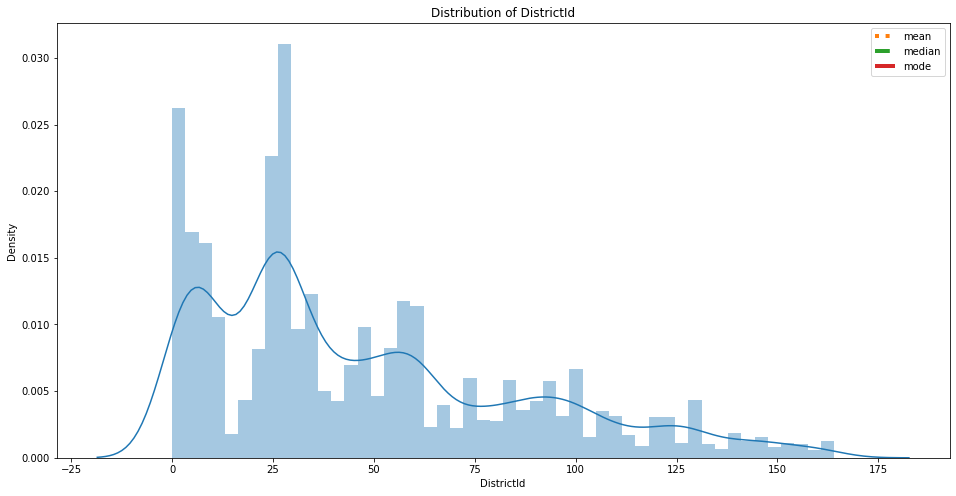

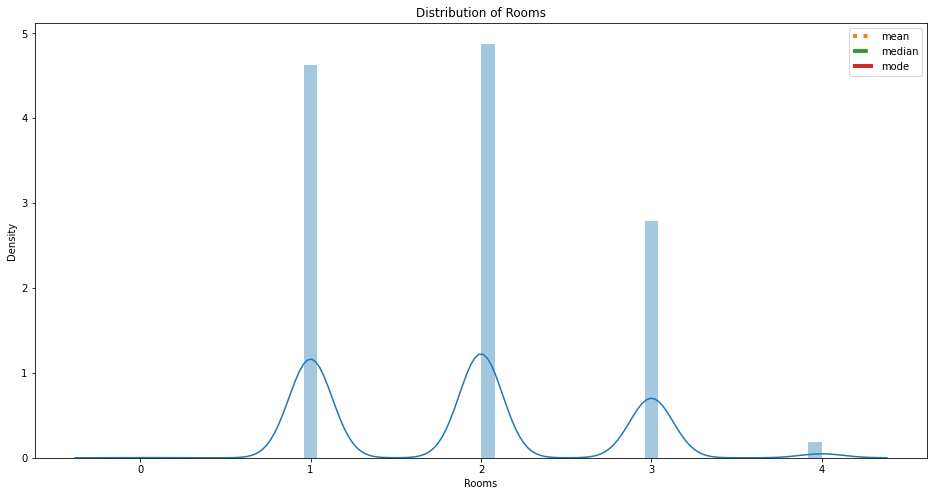

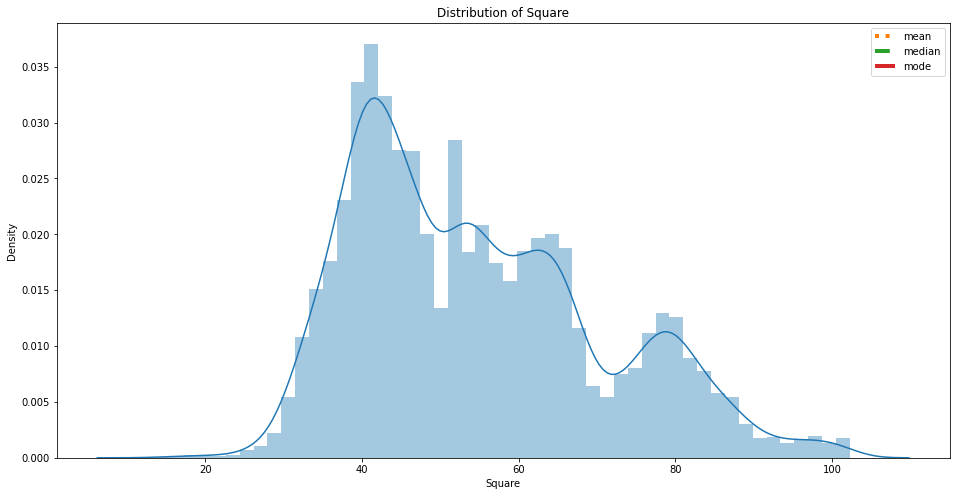

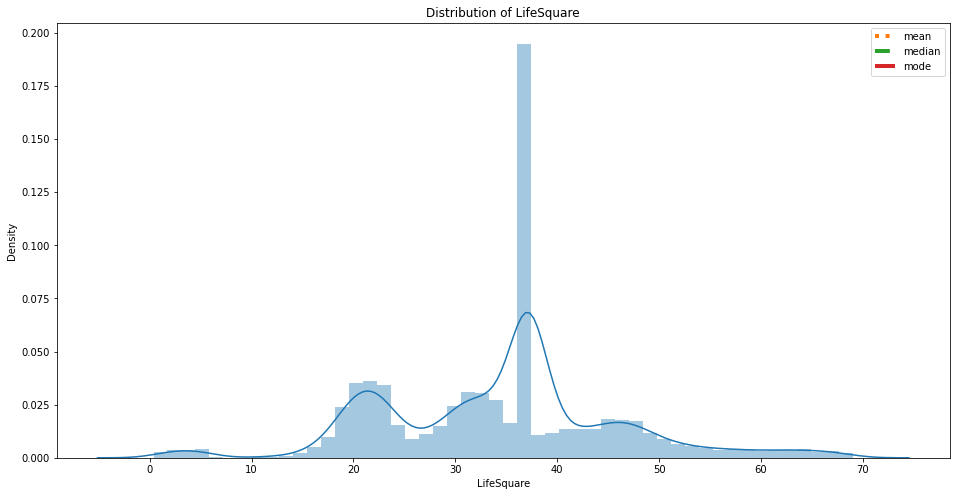

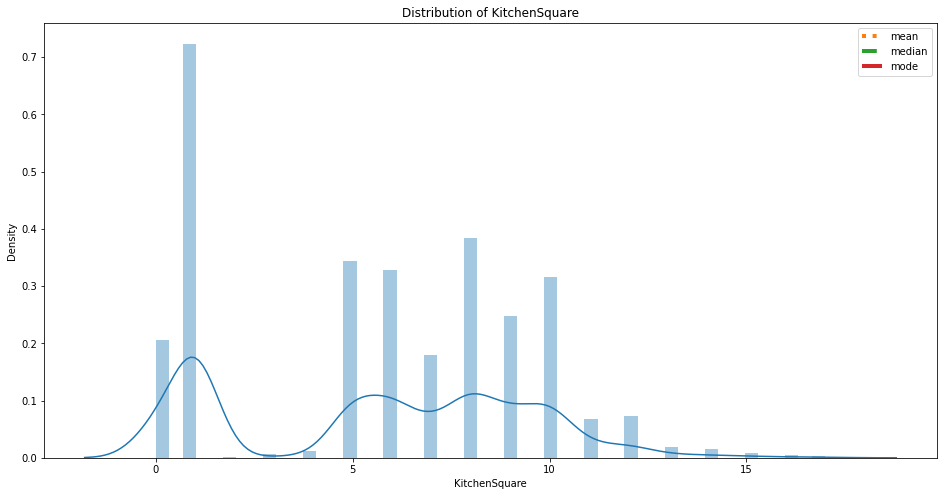

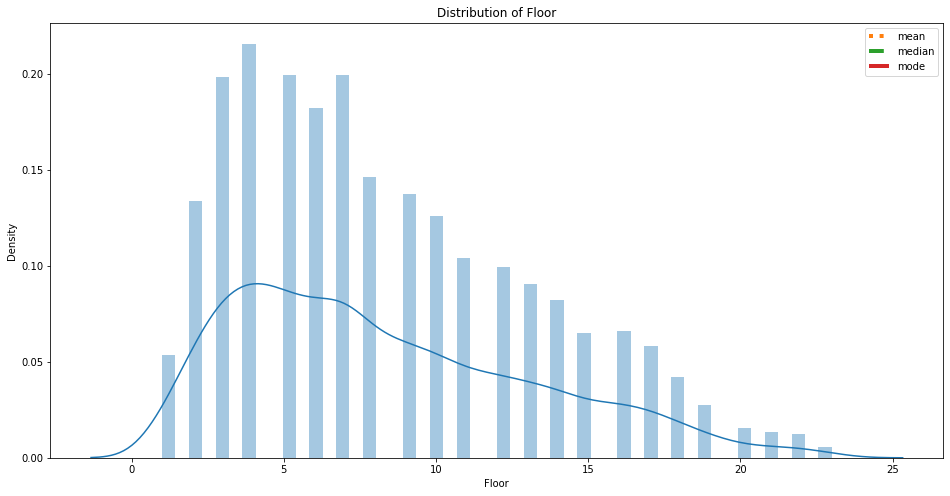

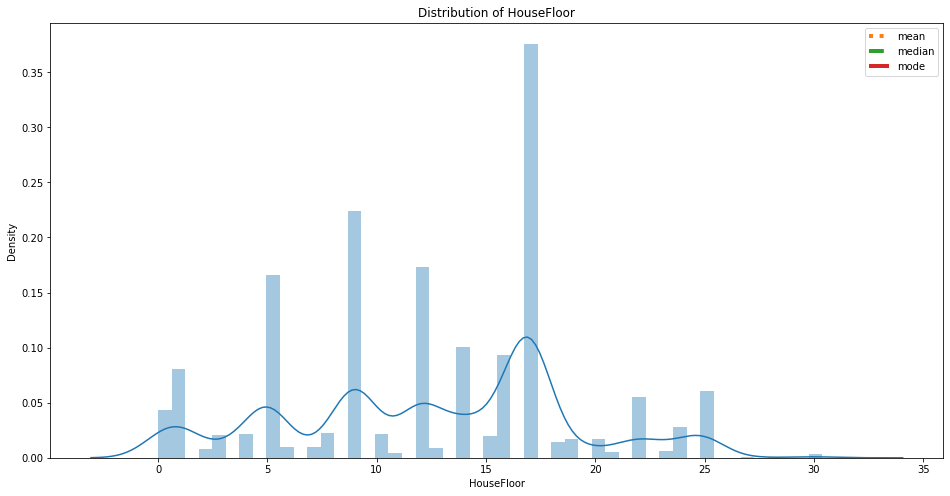

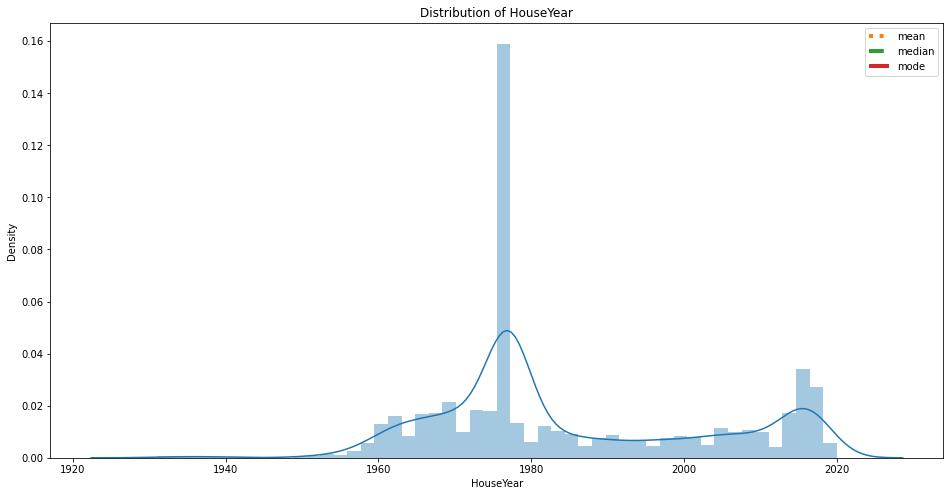

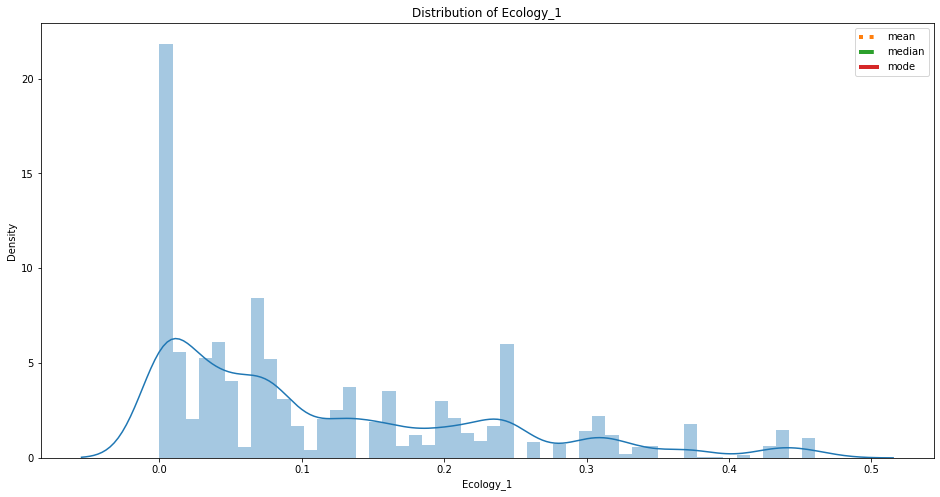

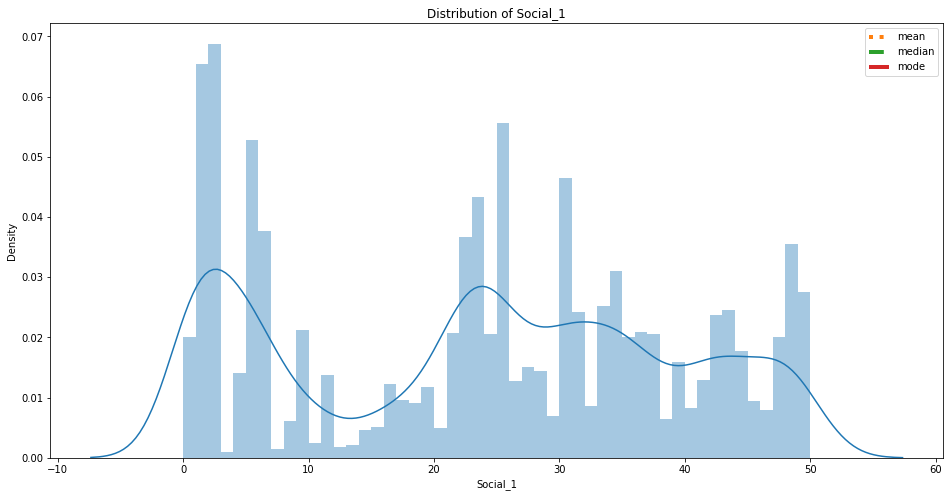

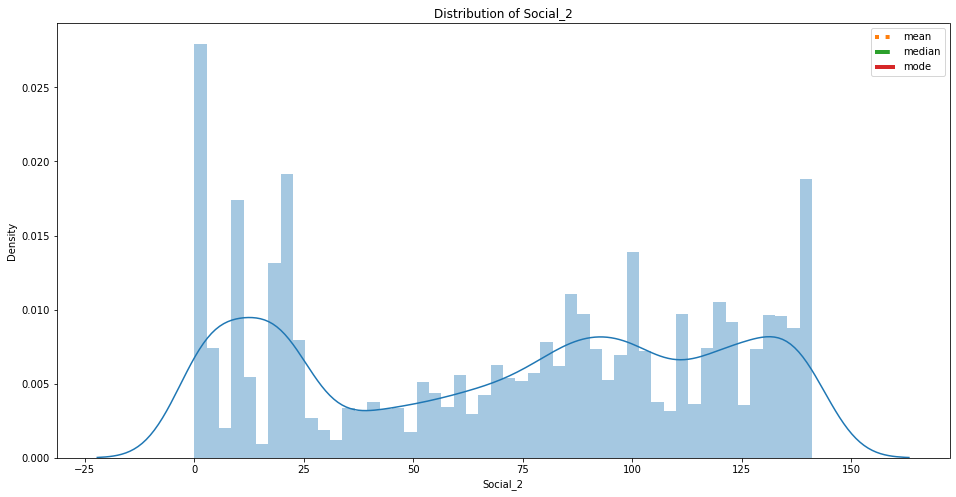

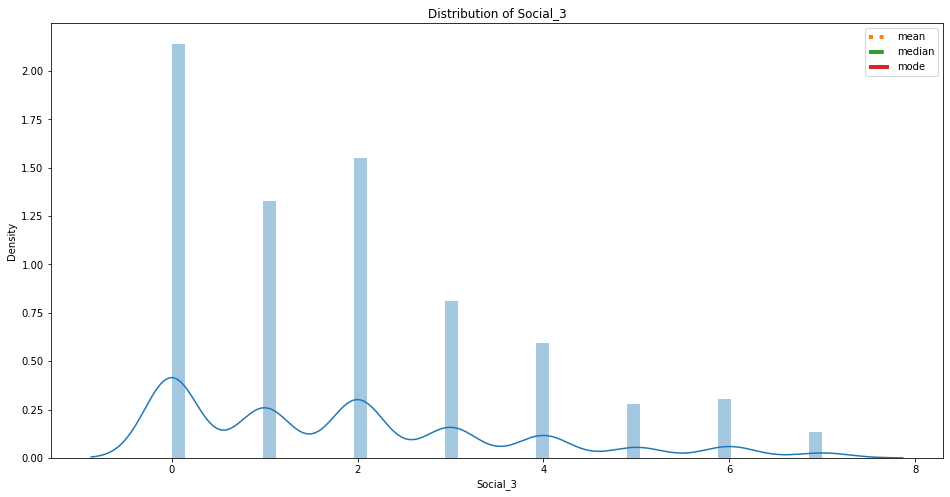

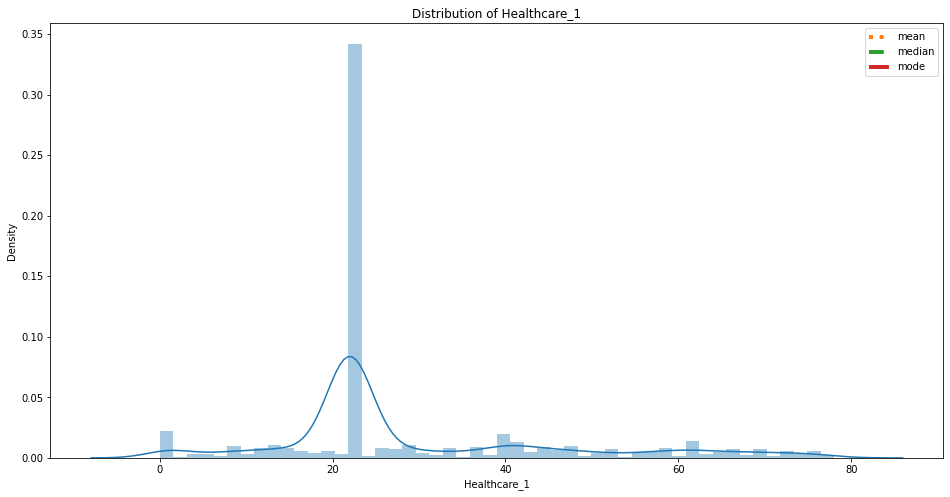

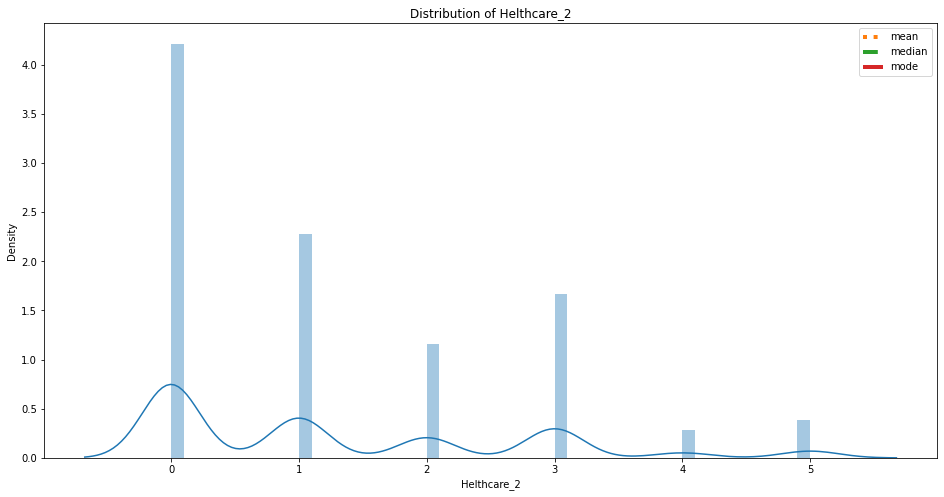

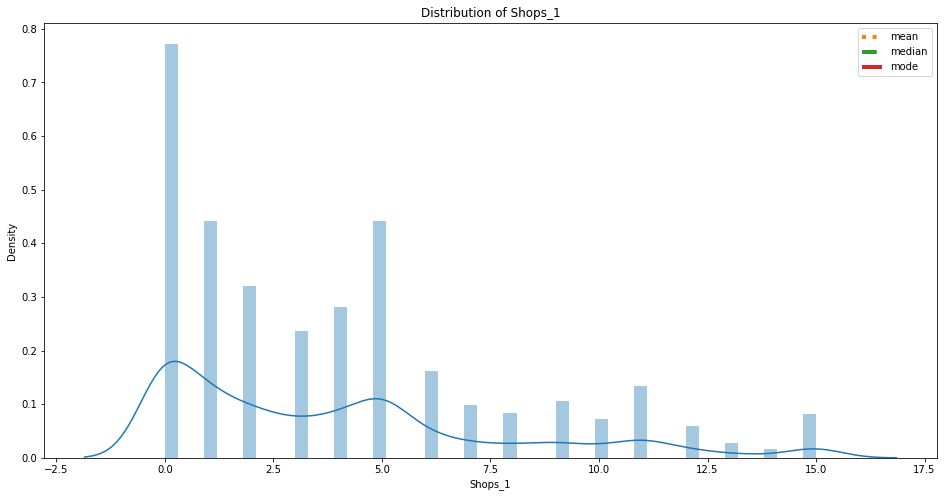

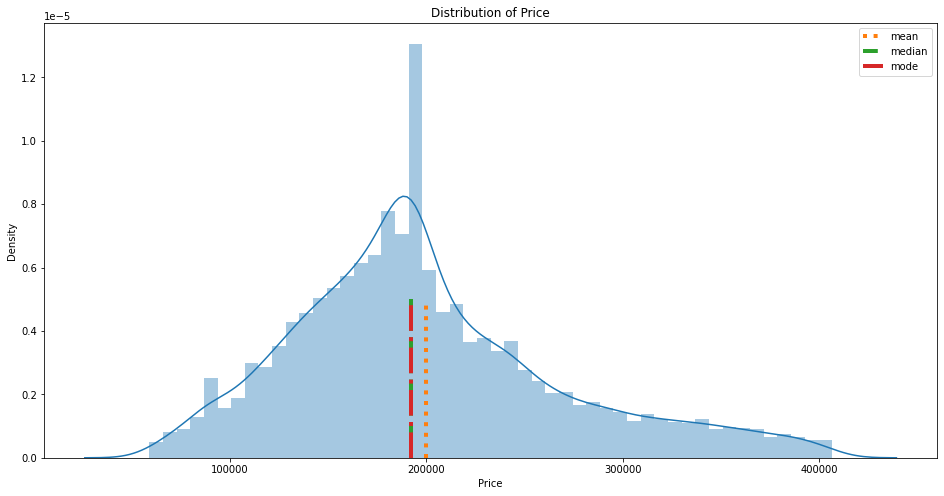

In [310]:
plt.figure(figsize = (16, 8))
# распределение количественных признаков в исходных данных и осноные статистические данные в них
pipeline.plot(pipeline.train_data)

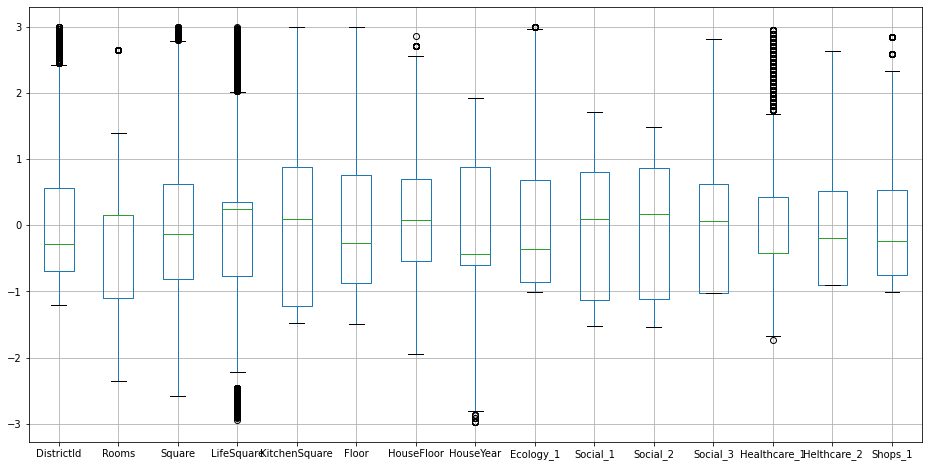

In [311]:
pipeline.boxplot(pipeline.sc_train_data)

In [312]:
pipeline.fit()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
2137,-0.876634,0.147888,0.068812,-0.390348,0.359362,-1.083399,-0.080492,0.771672,-0.220864,1.707100,1.488368,0.069526,-0.414804,2.629435,2.073964
1416,-0.518175,0.147888,0.464797,2.506211,1.148937,-1.083399,0.694960,1.763071,-0.856614,-1.394028,-1.436440,-1.030568,-0.414804,-0.895277,-1.011182
6767,0.352368,-1.099062,-1.012144,-1.270083,0.096170,-0.675216,-0.545763,-0.274805,1.600065,1.513279,1.273309,2.269713,-0.414804,-0.190334,1.302677
7400,1.325327,0.147888,-0.111952,0.019234,0.885746,-1.083399,-0.080492,-0.550193,-0.902747,0.737997,0.413071,-0.480521,1.924010,0.514608,0.017200
130,1.248515,-1.099062,-1.175859,-1.407228,-1.219789,-1.491582,-0.545763,-0.384960,-0.652647,1.577886,1.466862,1.169619,-0.414804,-0.190334,0.017200
2216,-0.518175,0.147888,0.543350,0.286062,-1.219789,1.773881,-1.786485,-0.440038,-0.856614,-1.394028,-1.436440,-1.030568,-0.414804,-0.895277,-1.011182
7469,1.376536,-1.099062,-1.332484,-1.104159,-0.167021,-0.267033,-1.166124,-1.100971,0.952620,1.061032,0.628130,2.819760,1.384284,1.219550,-0.496991
388,-0.620592,1.394839,1.540015,0.239444,-1.219789,2.386156,1.935682,-0.440038,-0.351403,-1.135601,-1.156863,0.619573,-0.414804,-0.895277,-0.496991
4243,-0.774217,1.394839,1.543749,0.867648,1.148937,0.141150,-0.700853,-1.376359,-1.009981,0.091929,0.047470,1.169619,-1.494256,-0.190334,-0.754087
8331,-0.518175,-1.099062,-1.230274,-0.888845,0.885746,-0.879308,-0.080492,-0.440038,-0.354489,-0.812567,-0.705238,-1.030568,-0.414804,-0.895277,-1.011182


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
mean,-6.377121e-17,8.171241e-17,-8.313350e-17,-2.700062e-16,3.188561e-17,-1.325162e-16,-3.197442e-18,3.712586e-15,-4.973799e-18,-8.952838e-17,7.709389e-17,5.826450e-17,1.104894e-16,-7.815970e-18,4.405365e-17
std,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00
min,-1.209489e+00,-2.346013e+00,-2.572914e+00,-2.940062e+00,-1.482980e+00,-1.491582e+00,-1.941576e+00,-2.973614e+00,-1.009981e+00,-1.523242e+00,-1.543970e+00,-1.030568e+00,-1.734135e+00,-8.952769e-01,-1.011182e+00
25%,-6.974046e-01,-1.099062e+00,-8.106813e-01,-7.682393e-01,-1.219789e+00,-8.793076e-01,-5.457629e-01,-6.052712e-01,-8.566143e-01,-1.135601e+00,-1.113851e+00,-1.030568e+00,-4.148036e-01,-8.952769e-01,-7.540869e-01
50%,-2.877374e-01,1.478883e-01,-1.363123e-01,2.394436e-01,9.617027e-02,-2.670333e-01,7.459845e-02,-4.400380e-01,-3.544886e-01,9.192907e-02,1.765057e-01,6.952591e-02,-4.148036e-01,-1.903344e-01,-2.398958e-01
75%,5.572012e-01,1.478883e-01,6.310299e-01,3.472770e-01,8.857456e-01,7.534240e-01,6.949598e-01,8.818275e-01,6.802878e-01,8.026043e-01,8.646958e-01,6.195727e-01,4.247706e-01,5.146080e-01,5.313908e-01
max,2.989600e+00,2.641790e+00,2.994155e+00,2.987729e+00,2.991280e+00,2.998430e+00,2.866224e+00,1.928304e+00,2.992627e+00,1.707100e+00,1.488368e+00,2.819760e+00,2.943493e+00,2.629435e+00,2.845251e+00
